In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import numpy as np
import pylab as plt

from scipy.optimize import least_squares
from scipy.ndimage import binary_dilation

from astropy.io import fits
from astropy.time import Time
from natsort import natsorted
from astropy.stats import sigma_clip
from astropy.convolution import Gaussian2DKernel, convolve

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from rotate import shiftRotateXYZ
from grid import regridXYZ, regridXYZMasked
from parabolas import loadLeicaData, parabola
from plotting import surfacePlot, barChartPlot, scatterPlot
from zernikies import zernikeWLS, getZernikeCoeffs, zernikePoly
from utils.utils import midPoint, getRollingStat, radialMask, makeGrid

In [64]:
def costParabolaSmallAngleZ(coef, x, y, z):
    """
    """
    
    xm = 50
    ym = 100
    
    fl = coef[0]
    x0 = coef[1]
    y0 = coef[2]
    z0 = coef[3]
    rx = coef[4]
    ry = coef[5]
    #c4 = coef[6]
    c5 = coef[6]
    #c6 = coef[8]
    xc = coef[7]
    yc = coef[8]
    
    crx = 1. - rx**2./2.
    srx = rx
    cry = 1. - ry**2./2.
    sry = ry
    
    xp = x*cry + y*srx*sry + z*crx*sry - x0
    yp = y*crx - z*srx - y0
    zp = -x*sry + y*srx*cry + z*crx*cry - z0
    
    xh = (xp - xc)/xm
    yh = (yp - yc)/ym
    
    xp2 = np.power(xp, 2.)
    yp2 = np.power(yp, 2.)
    xh2 = np.power(xh, 2.)
    yh2 = np.power(yh, 2.)
    
    fp = 1./(4.*fl)*(xp2 + yp2)
    #z4 = c4*(xh2 - yh2)
    z5 = c5*(2.*xh2 + 2.*yh2 - 1.)
    #z6 = c6*xh*yh
    #z9 = c9*(3*xh2*yh + 3*yh2*yh - 2*yh)
    
    return fp + z5 - zp

def jacParabolaSmallAngleZ(coef, x, y, z):
    """
    """
    
    xm = 50.
    ym = 100.
    
    fl = coef[0]
    x0 = coef[1]
    y0 = coef[2]
    z0 = coef[3]
    rx = coef[4]
    ry = coef[5]
    #c4 = coef[6]
    c5 = coef[6]
    #c6 = coef[8]
    #c9 = coef[9]
    xc = coef[7]
    yc = coef[8]
    
    crx = 1. - rx**2./2.
    srx = rx
    cry = 1. - ry**2./2.
    sry = ry
    
    xp = x*cry + y*srx*sry + z*crx*sry - x0
    yp = y*crx - z*srx - y0
    zp = -x*sry + y*srx*cry + z*crx*cry - z0
    
    dxdrx = y*ry - z*rx*ry
    
    dxdry = -x*ry + y*rx + z*crx
    
    dydrx = -y*rx - z
    
    dzdrx = y*cry - z*rx*cry
    
    dzdry = -x - y*rx*ry - z*crx*ry
    
    xh = (xp - xc)/xm
    yh = (yp - yc)/ym
    
    xp2 = np.power(xp, 2.)
    yp2 = np.power(yp, 2.)
    xh2 = np.power(xh, 2.)
    yh2 = np.power(yh, 2.)
    
    dxhdx = -1./xm # Same for dxh/dxc or dxh/dx0
    dyhdy = -1./ym # Same for dyh/dyc or dyh/dy0
    
    dxhdrx = dxhdx*dxdrx
    
    dxhdry = dxhdx*dxdry
    
    dyhdrx = dyhdy*dydrx
    
    dyhdry = 0.
    
    dGdfl = -1./(4.*fl**2.)*(xp2 + yp2)
    
    dGdx0 = -1./(4.*fl)*2.*xp + c5*4*xh*dxhdx #c4*2.*xh*dxhdx + c5*4*xh*dxhdx + c6*yh*dxhdx #+ c9*6*xh*yh*dxhdx
    
    dGdy0 = -1./(4.*fl)*2.*yp - c5*4*yh*dyhdy #c4*2.*yh*dyhdy + c5*4*yh*dyhdy + c6*xh*dyhdy #+ c9*(3*xh2 + 9*yh2 - 2)*dyhdy
    
    dGdz0 = np.ones(len(z))
    
    dGdrx = 1./(4.*fl)*(2.*xp*dxdrx + 2.*yp*dydrx) + c5*(4*xh*dxhdrx + 4*yh*dyhdrx) #+ c4*(2.*xh*dxhdrx - 2.*yh*dyhdrx) + \
            #c5*(4*xh*dxhdrx + 4*yh*dyhdrx) \
            #+ c6*(yh*dxhdrx + xh*dyhdrx) #+ c9*(6*xh*yh*dxhdrx + 3*xh*dyhdrx + 9*yh2*dyhdrx - 2*dyhdrx) - dzdrx
    
    dGdry = 1./(4.*fl)*(2.*x*dxdry) + c5*4.*xh*dxhdry #c4*2.*xh*dxhdry + c5*4.*xh*dxhdry #+ c6*yh*dxhdry + c9*6*xh*yh*dxhdry - dzdry
    
    #dGdc4 = (xh2 - yh2)
    
    dGdc5 = 2.*xh2 + 2.*yh2 - 1.
    
    #dGdc6 = xh*yh
    
    #dGdc9 = 3.*xh2*yh + 3.*yh2*yh - 2.*yh
    
    dGdxc = c5*4.*xh*dxhdx #c4*2.*xh*dxhdx + c5*4.*xh*dxhdx + c6*yh*dxhdx #+ c9*6*xh*yh*dxhdx
    
    dGdyc = c5*4.*yh*dyhdy #-c4*2.*yh*dyhdy + c5*4*yh*dyhdy + c6*xh*dyhdy #+ c9*(3*xh2*dyhdy + 9*yh2*dyhdy - 2*dyhdy)
    
    return np.array([dGdfl, dGdx0, dGdy0, dGdz0, dGdrx, dGdry, dGdc5, dGdxc, dGdyc]).T# dGdc4, dGdc5, dGdc6, dGdxc, dGdyc]).T # dGdc9, dGdxc, dGdyc]).T

def costParabola(coef, x, y, z):
    """
    """
    
    fl = coef[0]
    x0 = coef[1]
    y0 = coef[2]
    z0 = coef[3]
    rx = coef[4]
    ry = coef[5]
    
    crx = np.cos(rx)
    srx = np.sin(rx)
    cry = np.cos(ry)
    sry = np.sin(ry)
    
    xp = x*cry + y*srx*sry + z*crx*sry - x0
    yp = y*crx - z*srx - y0
    zp = -x*sry + y*srx*cry + z*crx*cry - z0
    
    xp2 = np.power(xp, 2.)
    yp2 = np.power(yp, 2.)
    
    fp = 1./(4.*fl)*(xp2 + yp2)
    
    return fp - zp


def jacParabola(coef, x, y, z):
    """
    """
    
    fl = coef[0]
    x0 = coef[1]
    y0 = coef[2]
    z0 = coef[3]
    rx = coef[4]
    ry = coef[5]
    
    crx = np.cos(rx)
    srx = np.sin(rx)
    cry = np.cos(ry)
    sry = np.sin(ry)
    
    xp = x*cry + y*srx*sry + z*crx*sry - x0
    yp = y*crx - z*srx - y0
    zp = -x*sry + y*srx*cry + z*crx*cry - z0
    
    xp2 = np.power(xp, 2.)
    yp2 = np.power(yp, 2.)
    
    dxdrx = y*crx*sry - z*srx*sry
    
    dxdry = -x*sry + y*srx*cry + z*crx*cry
    
    dydrx = -y*srx - z*crx
    
    dzdrx = y*crx*cry - z*srx*cry
    
    dzdry = -x*cry - y*srx*sry - z*crx*sry
    
    # Jacobian columns.
    dGdfl = -1/(4*fl**2)*(xp2 + yp2)
    
    dGdx0 = -1/(4*fl)*2*xp
    
    dGdy0 = -1/(4*fl)*2*yp
    
    dGdz0 = np.ones(len(z))
    
    dGdrx = 1/(4*fl)*(2*xp*dxdrx + 2*yp*dydrx) - dzdrx
    
    dGdry = 1/(4*fl)*(2*x*dxdry) - dzdry
    
    return np.array([dGdfl, dGdx0, dGdy0, dGdz0, dGdrx, dGdry]).T

def parabolaFit(x, y, z, guess, method=costParabola, jac=jacParabola, 
                bounds=None,  max_nfev=10000, ftol=1e-12, xtol=1e-12, gtol=1e-12, 
                f_scale=1e-5, tr_solver=None, x_scale=None, verbose=False):
    
    # Set boundaries for the fit parameters.
    if bounds is None:
        inf = np.inf
        pi2 = 2*np.pi
        cmin = -inf
        cmax = inf
        if len(guess) == 12:
            b1 = [60-15e-3, -inf, -inf, -inf, -pi2, -pi2, cmin, cmin, cmin, cmin, -2, 48]
            b2 = [60+15e-3,  inf,  inf,  inf,  pi2,  pi2, cmax, cmax, cmax, cmax,  2, 52]
        else:
            b1 = [60-15e-3, -inf, -inf, -inf, -pi2, -pi2]
            b2 = [60+15e-3,  inf,  inf,  inf,  pi2,  pi2]
            
            #b1 = [0., -inf, -inf, -inf, -pi2, -pi2]
            #b2 = [inf, inf,  inf,  inf,  pi2,  pi2]
            
        bounds = (b1, b2)
        
    # Robust fit: weights outliers outside of f_scale less
    loss = "soft_l1"
    
    if x_scale is None:
        xsr = np.deg2rad(0.001)
        xsz = 5e-5
        if len(guess) == 12:
            x_scale = [1e-3, 0.1, 0.1, 0.1, xsr, xsr, xsz, xsz, xsz, xsz, 0.1/50., 0.1/100.]
        else:
            x_scale = [1e-3, 0.1, 0.1, 0.1, xsr, xsr]
    
    if jac == None:
        jac = "3-point"
    
    args = (x.flatten(), y.flatten(), z.flatten())
    
    r = least_squares(method, guess, jac,
                      args=args,
                      bounds=bounds,
                      max_nfev=max_nfev,
                      loss=loss,
                      f_scale=f_scale,
                      ftol=ftol,
                      xtol=xtol,
                      gtol=gtol,
                      x_scale=x_scale,
                      tr_solver=tr_solver)
    return r


def removeParabolaFit(x, y, z, fit):
    cor = np.hstack((-1*fit[1:4],fit[4:6],0))
    xgdr, ygdr, zgdr = shiftRotateXYZ(x, y, z, cor)
    zp = parabola(xgdr, ygdr, fit[0])
    diff = zgdr - zp
    return xgdr, ygdr, diff


def alignParabola(x, y, z, fit):
    cor = np.hstack((-1*fit[1:4],fit[4:6],0))
    xr, yr, zr = shiftRotateXYZ(x, y, z, cor)
    return xr, yr, zr


def parabolaFitIterations(x, y, z, guess=[60., 0, 0, -50., 0, 0], bounds=None, iters=2, f_scale=1e-5):
    
    mask = np.isnan(z)
    
    for i in range(iters):
        x_ = x[~mask]
        y_ = y[~mask]
        z_ = z[~mask]
        fit = parabolaFit(x_, y_, z_, guess, method=costParabola, jac=jacParabola, 
                          bounds=bounds, f_scale=f_scale)
        cor = np.hstack((-1*fit.x[1:4],fit.x[4:],0))
        xdr, ydr, zdr = shiftRotateXYZ(x, y, z, cor)
        zp = parabola(xdr, ydr, fit.x[0])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = sigma_clip(zdr - zp)
        mask = res.mask
        guess = fit.x
    
    return fit, mask

def initLeicaData(filename, n=512, rz=178):
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    xg, yg, zg = regridXYZ(x, y, z, n=n)
    xg, yg, zg = shiftRotateXYZ(xg, yg, zg, [0, 0, 0, 0, 0, np.deg2rad(rz)])
    
    return xg, yg, zg

def guessRotations(zp, zr, n=512):
    """
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        zx0 = np.nanmean(sigma_clip(zr[n//2,0:20]))
        zxf = np.nanmean(sigma_clip(zr[n//2,n//2-10:n//2+10]))
    zpf = np.nanmean(zp[n//2,n//2-10:n//2+10])
    
    rx0 = (zpf - (zxf - zx0))/50.
    print(rx0)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        zyc = np.nanmean(sigma_clip(zr[n//2-10:n//2+10,n//2]))
        zyl = np.nanmean(sigma_clip(zr[0:20,n//2]))
        zyr = np.nanmean(sigma_clip(zr[-20:,n//2]))
    zpc = np.nanmean(zp[n//2-10:n//2+10,n//2])
    zpl = np.nanmean(zp[0:20,n//2])
    zpr = np.nanmean(zp[-20:,n//2])
    
    ry01 = ((zpl - zpc) - (zyl - zyc))/50.
    ry02 = ((zpr - zpc) - (zyr - zyc))/50.
    print(ry01, ry02)
    if ry01 > ry02:
        sign = 1.
    else:
        sign = -1.
    ry0 = sign*np.mean((abs(ry01), abs(ry02)))
    print(ry0)
    
    return rx0, ry0

In [31]:
n = 512
iters = 1
nZern = 36
iz = 4
izv = -486
zcoef = np.zeros(nZern)
zcoef[iz] = izv*1e-6
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'
refScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
sigScan = "{0}/2020_03_16_03:02:51.ptx.csv".format(scanDir) # C4=-486

In [16]:
%%time
fl = 60.
xmin = -50
xmax = 50
ymin = 0.01
ymax = 100

dx = (xmax - xmin)/n
dy = (ymax - ymin)/n
xx, yy, zz = makeGrid(xmin, xmax, dx, ymin, ymax, dy)

zp = parabola(xx, yy, fl)
zp[~radialMask(xx, yy, 50)] = np.nan
zz += zp

CPU times: user 23.5 ms, sys: 1.74 ms, total: 25.3 ms
Wall time: 23.6 ms


In [6]:
%%time
xr, yr, zr = initLeicaData(refScan, n=n, rz=178)

CPU times: user 7.97 s, sys: 1.72 s, total: 9.69 s
Wall time: 7.24 s


In [7]:
%%time
xs, ys, zs = initLeicaData(sigScan, n=n, rz=178)

CPU times: user 3.91 s, sys: 865 ms, total: 4.78 s
Wall time: 3.39 s


In [48]:
%%time
# Mask bad data.
rFit, rMask = parabolaFitIterations(xr, yr, zr, guess=[60., 0, 0, -50., 0, 0], bounds=None, iters=2, f_scale=1e-5)
zrm = np.copy(zr)
zrm[rMask] = np.nan

CPU times: user 1min 23s, sys: 1min 16s, total: 2min 39s
Wall time: 8.39 s


In [49]:
%%time
# Try to mask bad data.
sFit, sMask = parabolaFitIterations(xs, ys, zs, guess=[60., 0, 0, -50., 0, 0], bounds=None, iters=2, f_scale=1e-5)
zsm = np.copy(zs)
zsm[sMask] = np.nan

CPU times: user 51.3 s, sys: 47.9 s, total: 1min 39s
Wall time: 5.4 s


<IPython.core.display.Javascript object>


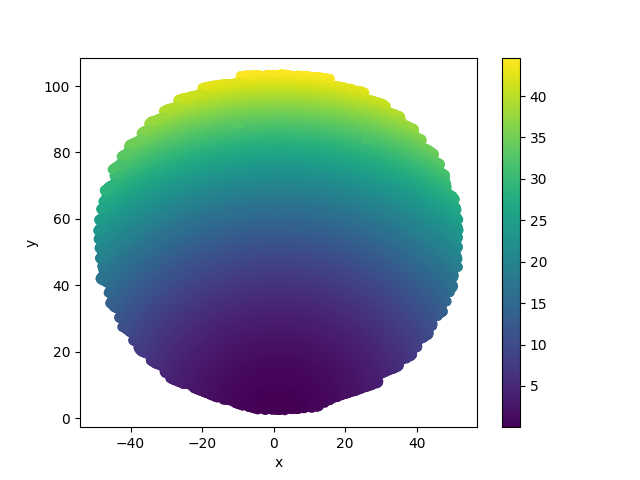

<IPython.core.display.Javascript object>


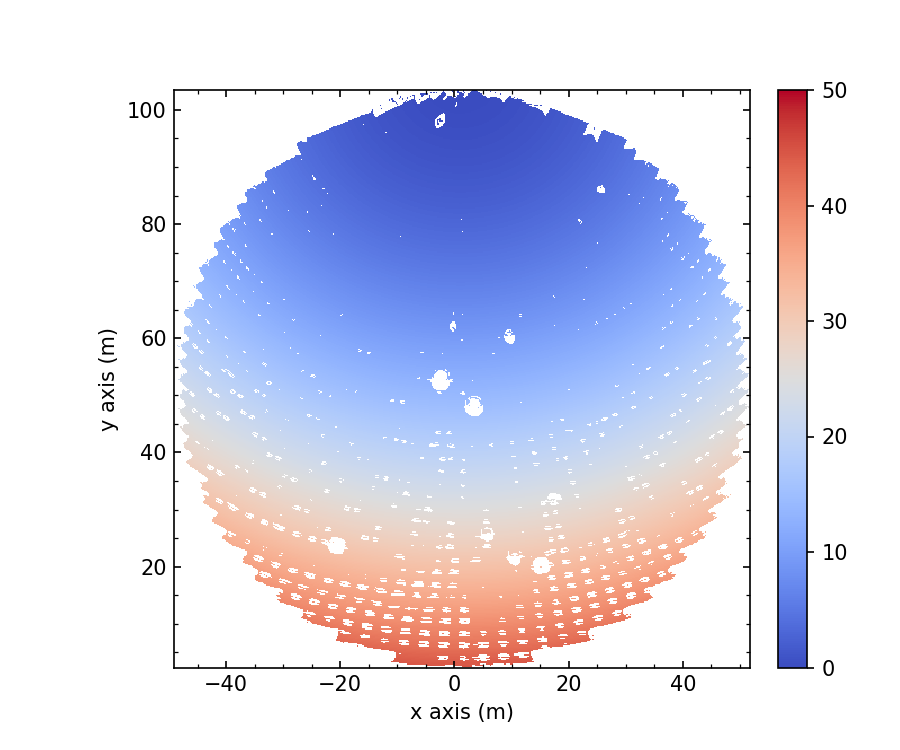

CPU times: user 56.9 s, sys: 52.8 s, total: 1min 49s
Wall time: 6.07 s


In [51]:
%%time
# Fit a parabola and align the data.
rFit1 = parabolaFit(xr[~np.isnan(zrm)], yr[~np.isnan(zrm)], zr[~np.isnan(zrm)], 
                    [60, 0, 0, -50, 0, 0], method=costParabola, jac=jacParabola,
                    bounds=None, max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-4, 
                    verbose=False)
xra, yra, zra = alignParabola(xr, yr, zrm, rFit1.x)
scatterPlot(xra, yra, zra)
surfacePlot(xra, yra, zra.T, vMin=0, vMax=50, midPoint=25)

<IPython.core.display.Javascript object>


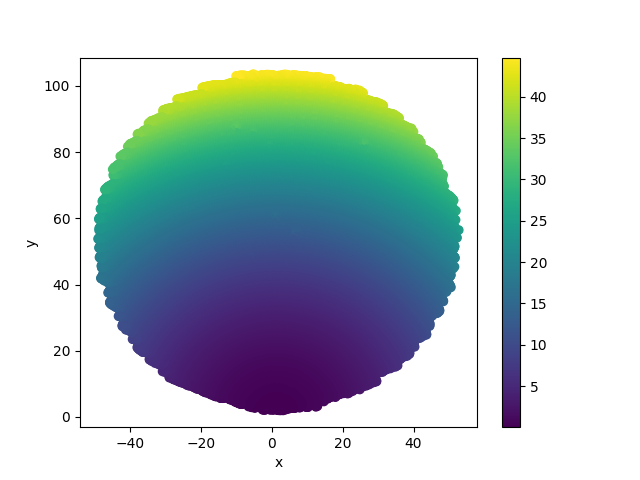

<IPython.core.display.Javascript object>


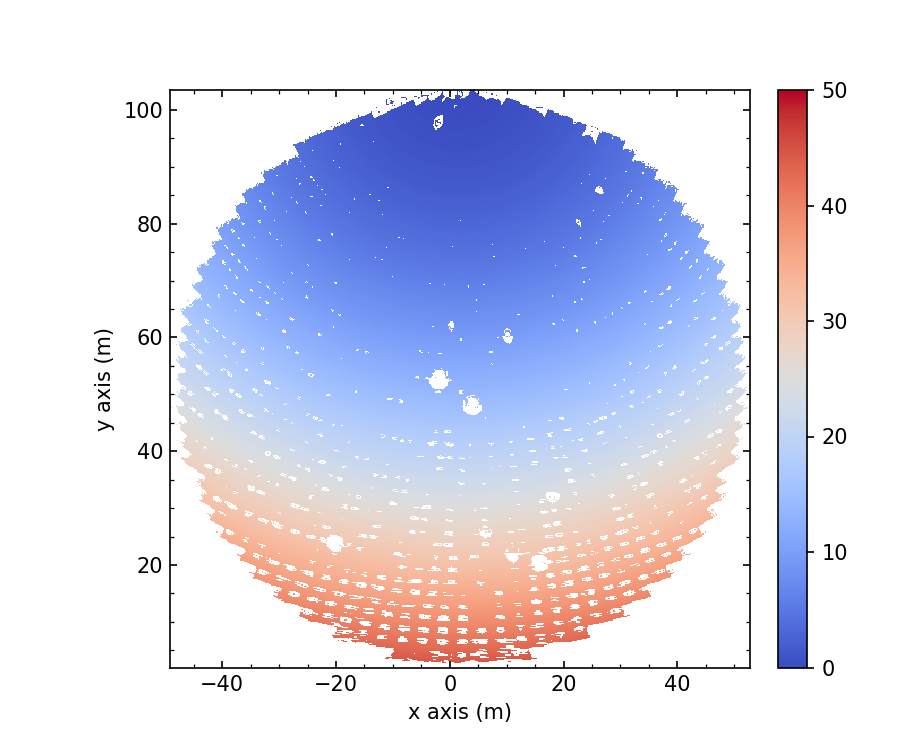

CPU times: user 1min 3s, sys: 59.6 s, total: 2min 3s
Wall time: 6.7 s


In [52]:
%%time
# Fit a parabola and align the data.
sFit1 = parabolaFit(xs[~np.isnan(zsm)], ys[~np.isnan(zsm)], zs[~np.isnan(zsm)], 
                    [60, 0, 0, -50, 0, 0], method=costParabola, jac=jacParabola,
                    bounds=None, max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-4, 
                    verbose=False)
xsa, ysa, zsa = alignParabola(xs, ys, zsm, sFit1.x)
scatterPlot(xsa, ysa, zsa)
surfacePlot(xsa, ysa, zsa.T, vMin=0, vMax=50, midPoint=25)

In [55]:
rx0r, ry0r = guessRotations(zp, zra[:,::-1], n=512)
rx0s, ry0s = guessRotations(zp, zsa[:,::-1], n=512)

-0.04448916761759403
0.016758824090314803 0.012593904637547908
0.014676364363931355
-0.04581222040616161
0.015499477257265432 0.012034340298652175
0.013766908777958803


In [71]:
%%time
inf = np.inf
cmin = -1e-3
cmax = 1e-3
drx = 5e-4
dry = 5e-4
flfit = rFit1.x[0]
lb = [flfit-5e-3, -3, -10, -3, rx0r-drx, ry0r-dry, cmin, -2, 48]
ub = [flfit+5e-3,  3,  10,  3, rx0r+drx, ry0r+dry, cmax,  2, 52]
bounds = (lb, ub)

xsr = np.deg2rad(0.00025)
xsz = 5e-5
x_scale = [1e-3, 0.1, 0.1, 0.1, xsr, xsr, xsz, 0.1/50., 0.1/100.]

rFit2 = parabolaFit(xra[~np.isnan(zra)], yra[~np.isnan(zra)], zra[~np.isnan(zra)],
                    [flfit, 0, 0, 0, rx0r, ry0r, 0, 0, 50], method=costParabolaSmallAngleZ, 
                    jac=jacParabolaSmallAngleZ, bounds=bounds, max_nfev=5000, 
                    ftol=1e-10, xtol=1e-10, f_scale=1e-4, x_scale=x_scale, verbose=False)
#print(fit2)
#rDiff = removeParabolaFit(xra, yra, zra, rFit2.x)
#surfacePlot(xra, yra, rDiff.T, vMin=-2e-4, vMax=2e-4)
#diff_ = np.ma.masked_invalid(rDiff)
#zfit = getZernikeCoeffs(diff_.filled(0).T, 36, norm='active-surface')
#barChartPlot(np.arange(4,36), zfit[4:36]*1e6, expected=zcoef[4:36]*1e6)

CPU times: user 26.6 s, sys: 24.1 s, total: 50.7 s
Wall time: 3.76 s


In [72]:
%%time
inf = np.inf
cmin = -1e-3
cmax = 1e-3
drx = 5e-4
dry = 5e-4
flfit = sFit1.x[0]
lb = [flfit-5e-3, -3, -10, -3, rx0s-drx, ry0s-dry, cmin, -2, 48]
ub = [flfit+5e-3,  3,  10,  3, rx0s+drx, ry0s+dry, cmax,  2, 52]
bounds = (lb, ub)

xsr = np.deg2rad(0.00025)
xsz = 5e-5
x_scale = [1e-3, 0.1, 0.1, 0.1, xsr, xsr, xsz, 0.1/50., 0.1/100.]

sFit2 = parabolaFit(xsa[~np.isnan(zsa)], ysa[~np.isnan(zsa)], zsa[~np.isnan(zsa)],
                    [flfit, 0, 0, 0, rx0s, ry0s, 0, 0, 50], method=costParabolaSmallAngleZ, 
                    jac=jacParabolaSmallAngleZ, bounds=bounds, max_nfev=5000, 
                    ftol=1e-10, xtol=1e-10, f_scale=1e-4, x_scale=x_scale, verbose=False)

CPU times: user 20.5 s, sys: 18.2 s, total: 38.7 s
Wall time: 2.66 s


In [73]:
print(rx0r, ry0r)
print(rx0s, ry0s)

-0.04448916761759403 0.014676364363931355
-0.04581222040616161 0.013766908777958803


<IPython.core.display.Javascript object>


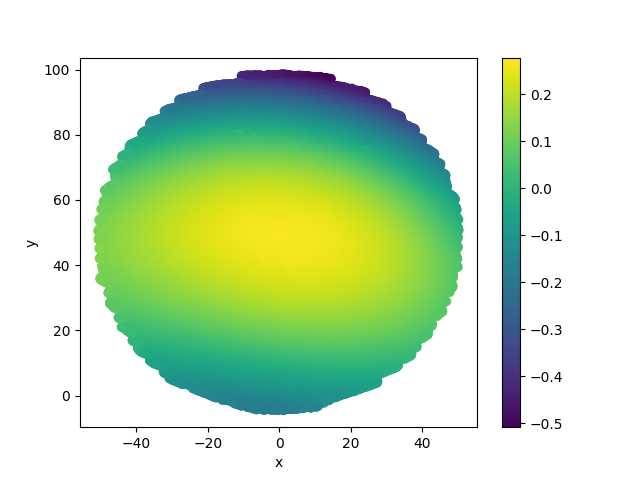

<IPython.core.display.Javascript object>


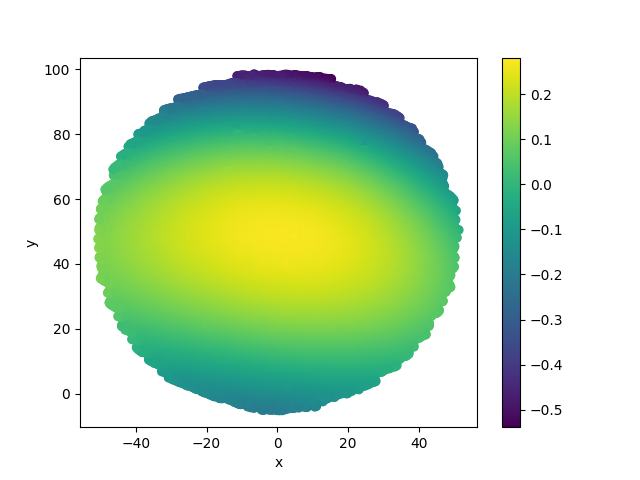

<IPython.core.display.Javascript object>


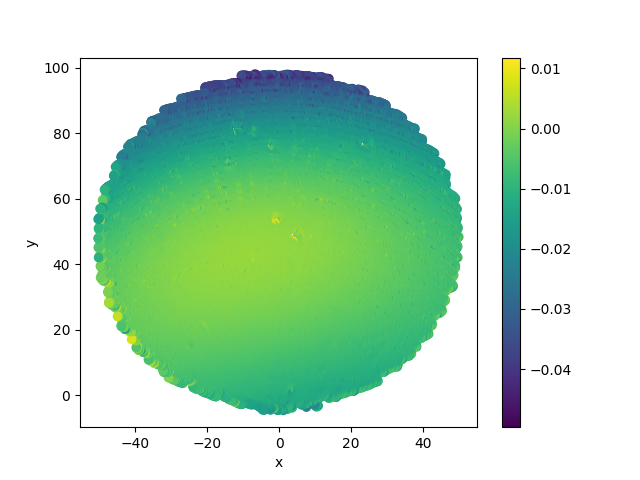

<IPython.core.display.Javascript object>


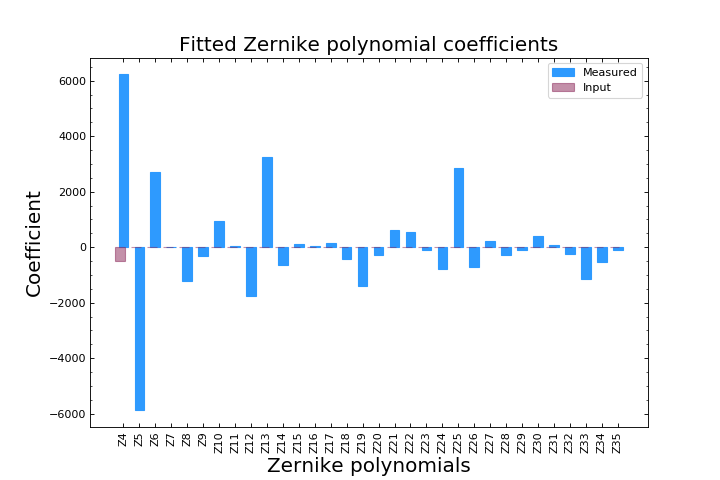

[-6.71362020e-03  5.88019938e-03 -2.72144441e-03 -3.27520162e-06
  1.23149461e-03  3.18390455e-04 -9.53536390e-04 -5.30347042e-05
  1.76515782e-03 -3.25289827e-03  6.40868546e-04 -1.26506474e-04
 -3.77412796e-05 -1.68847424e-04  4.09857947e-04  1.41359405e-03
  2.87437809e-04 -6.05565344e-04 -5.53639197e-04  1.06863957e-04
  7.86022207e-04 -2.86477082e-03  7.07080521e-04 -2.26906063e-04
  2.73313491e-04  9.80638032e-05 -4.00940866e-04 -6.21399877e-05
  2.48814232e-04  1.14846664e-03  5.29879645e-04  1.17088827e-04]


In [74]:
xra_, yra_, rDiff2 = removeParabolaFit(xra, yra, zra, np.hstack((60,rFit2.x[1:3],0,rx0r,ry0r)))
#surfacePlot(xra, yra, rDiff2, vMin=-2e-4, vMax=2e-4)
xsa_, ysa_, sDiff2 = removeParabolaFit(xsa, ysa, zsa, np.hstack((60,sFit2.x[1:3],0,rx0s,ry0s)))
#surfacePlot(xsa, ysa, sDiff2, vMin=-2e-4, vMax=2e-4)

scatterPlot(xra_, yra_, rDiff2)
scatterPlot(xsa_, ysa_, sDiff2)


diff = sDiff2 - rDiff2
scatterPlot(xra_, yra_, diff)

diff_ = np.ma.masked_invalid(diff)
zfit = getZernikeCoeffs(diff_.filled(0).T, 36, norm='active-surface')
barChartPlot(np.arange(4,36), zfit[4:36]*1e6, expected=zcoef[4:36]*1e6)
print(zcoef[4:36] - zfit[4:36])

In [70]:
rFit1.x, sFit1.x

(array([ 6.00150000e+01,  2.45248529e+00, -1.00183145e+00, -4.93033574e+01,
         2.20016153e-01, -5.06829986e-03]),
 array([ 6.00150000e+01,  2.45366061e+00, -9.96924845e-01, -4.93029608e+01,
         2.19993836e-01, -5.03471920e-03]))